In [20]:
# get data
from pathlib import Path

DISTANCE = 10

directory = Path('../data/external/PokemonData')

extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp']

all_files = 0
image_files = []

for dir in directory.iterdir():
    if dir.is_dir():
        for ext in extensions:
            image_files.extend(dir.glob(f'*{ext}'))
            image_files.extend(dir.glob(f'*{ext.upper()}'))







In [21]:
import cv2
import numpy as np
import pandas as pd

NEIGHBORHOOD_SIZE = 3
PADDING = NEIGHBORHOOD_SIZE // 2

# process data 
def convert_image(img_path):
    gray_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return gray_img

def extract_pixel_pairs(img_path):
    gray_img = convert_image(img_path)

    height, width = gray_img.shape
    
    padded_image = np.pad(gray_img, ((PADDING,PADDING), (PADDING,PADDING)), mode='reflect')
    
    features = []
    targets = []

    for i in range(height):
        for j in range(width):

            neighborhood = padded_image[i:i+NEIGHBORHOOD_SIZE,j:j+NEIGHBORHOOD_SIZE]

            center_idx = NEIGHBORHOOD_SIZE // 2

            feature_pixels = []

            for ni in range(NEIGHBORHOOD_SIZE):
                for nj in range(NEIGHBORHOOD_SIZE):
                    if ni != center_idx or nj != center_idx:
                        feature_pixels.append(neighborhood[ni,nj])

            features.append(feature_pixels)
            targets.append(gray_img[i,j])

    return np.array(features), np.array(targets)





  



In [22]:
features, targets = extract_pixel_pairs(image_files[0])

print(features.shape)
print(targets.shape)



(401320, 8)
(401320,)


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score


model = LinearRegression()

# model.fit(features, targets)

# score = model.score(features, targets)
# print(f"Training completed on {len(features)} pixel neighborhoods")
# print(f"Model R² score: {score:.3f}")
# print(f"Number of features per pixel: {features.shape[1]}")

# print("Linear Regression Model Trained Successfully!")
# print(f"\nIntercept: {model.intercept_:.4f}")
# print("\nCoefficients:")
# for i, coef in enumerate(model.coef_):
#     print(f"Pixel {i}: {coef:.4f}")


X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.9999, random_state=42)

model.fit(X_train, y_train)
score = model.score(X_train, y_train)
print(f"Training completed on {len(X_train)} pixel neighborhoods")
print(f"Model R² score: {score:.3f}")
print(f"Number of features per pixel: {X_train.shape[1]}")

print("Linear Regression Model Trained Successfully!")
print(f"\nIntercept: {model.intercept_:.4f}")
print("\nCoefficients:")
for i, coef in enumerate(model.coef_):
    print(f"Pixel {i}: {coef:.4f}")

Training completed on 40 pixel neighborhoods
Model R² score: 0.985
Number of features per pixel: 8
Linear Regression Model Trained Successfully!

Intercept: 0.0237

Coefficients:
Pixel 0: -0.1792
Pixel 1: 0.2470
Pixel 2: 0.0170
Pixel 3: 0.3943
Pixel 4: 0.1455
Pixel 5: -0.2118
Pixel 6: 0.5901
Pixel 7: 0.0055


In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)



# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Performance Metrics:")
print(f"{'Metric':<15} {'Training':<12} {'Testing':<12}")
print("-" * 40)
print(f"{'R² Score':<15} {train_r2:<12.4f} {test_r2:<12.4f}")
print(f"{'MSE':<15} {train_mse:<12.4f} {test_mse:<12.4f}")
print(f"{'RMSE':<15} {np.sqrt(train_mse):<12.4f} {np.sqrt(test_mse):<12.4f}")
print(f"{'MAE':<15} {train_mae:<12.4f} {test_mae:<12.4f}")

#Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"\n5-Fold Cross-Validation R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Performance Metrics:
Metric          Training     Testing     
----------------------------------------
R² Score        0.9854       0.9713      
MSE             68.1459      130.8654    
RMSE            8.2551       11.4396     
MAE             6.0320       7.9573      

5-Fold Cross-Validation R² Score: 0.9481 (+/- 0.0934)


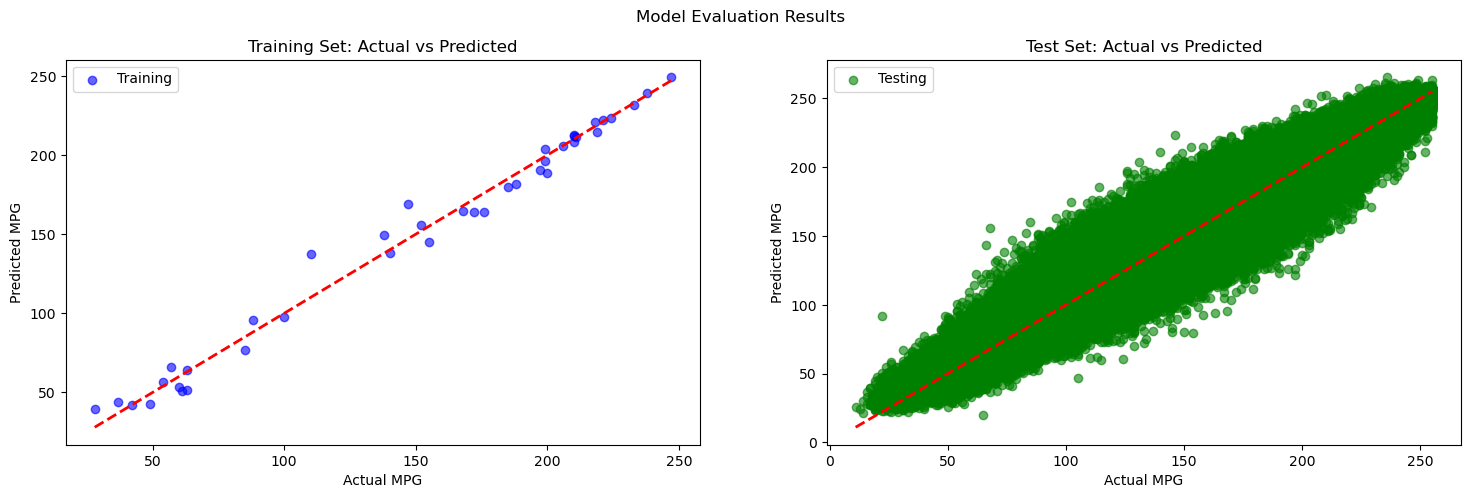

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('Model Evaluation Results')

# 1. Actual vs Predicted (Training)

axes[0].scatter(y_train, y_train_pred, alpha=0.6, color='blue', label='Training')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual MPG')
axes[0].set_ylabel('Predicted MPG')
axes[0].set_title('Training Set: Actual vs Predicted')
axes[0].legend()

# 2. Actual vs Predicted (Testing)
axes[1].scatter(y_test, y_test_pred, alpha=0.6, color='green', label='Testing')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual MPG')
axes[1].set_ylabel('Predicted MPG')
axes[1].set_title('Test Set: Actual vs Predicted')
axes[1].legend()

In [26]:
def extract_features_corrupted(img,mask):
    height, width = img.shape
    
    # Pad the corrupted image (this will include the corrupted pixels as 0s)
    padded_image = np.pad(img, ((PADDING,PADDING), (PADDING,PADDING)), mode='reflect')
    
    features = []
    pixel_positions = []
    
    for i in range(height):
        for j in range(width):
            if mask[i, j]:  # Only process corrupted pixels
                
                neighborhood = padded_image[i:i+NEIGHBORHOOD_SIZE, j:j+NEIGHBORHOOD_SIZE]
                center_idx = NEIGHBORHOOD_SIZE // 2
                feature_pixels = []
                
                for ni in range(NEIGHBORHOOD_SIZE):
                    for nj in range(NEIGHBORHOOD_SIZE):
                        if ni != center_idx or nj != center_idx:
                            feature_pixels.append(neighborhood[ni, nj])
                
                features.append(feature_pixels)
                pixel_positions.append((i, j))
    
    return np.array(features), pixel_positions

(632, 635)
(632, 635, 3)


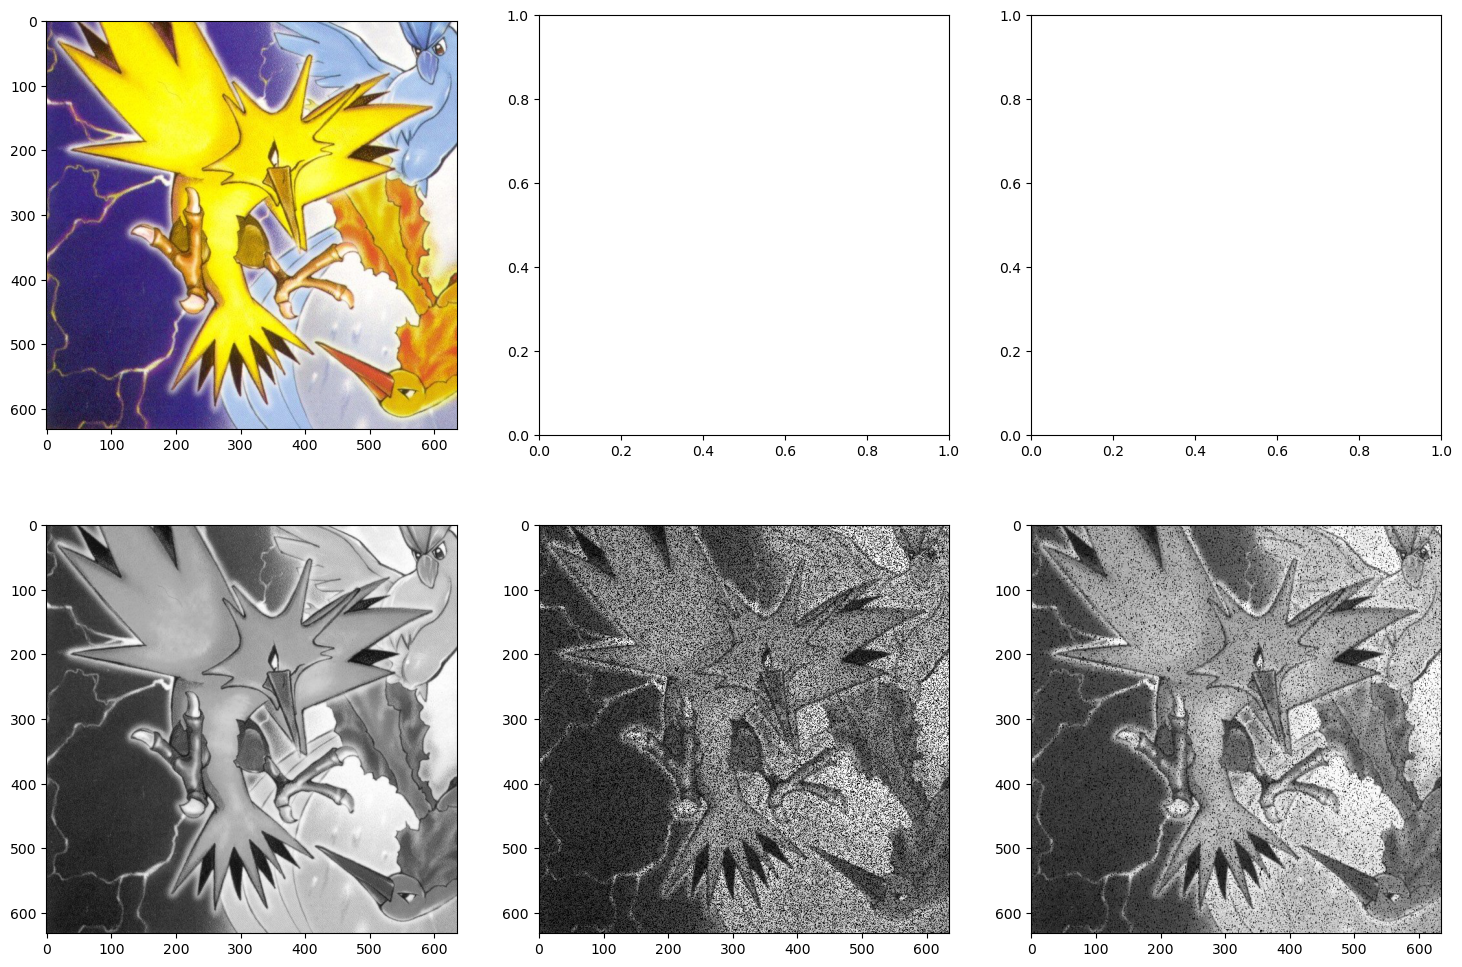

In [27]:
import matplotlib.pyplot as plt

original_image = cv2.imread(image_files[0])
gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
corrupted_image = gray_image.copy()
mask = np.random.random(corrupted_image.shape) < 0.3  # Remove 30% of pixels

corrupted_image[mask] = 0  # Set to black

features_corrupted , pixel_pos = extract_features_corrupted(corrupted_image, mask)

predictions = model.predict(features_corrupted)

predictions = np.clip(predictions, 0 , 255).astype(np.uint8)

reconstructed = corrupted_image.copy()

for idx, (i,j) in enumerate(pixel_pos):
    reconstructed[i,j] = predictions[idx]

fig, axes = plt.subplots(2,3, figsize=(18,12))


# zapdos = cv2.imread(image_files[0])
# rgb_img = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)
# print(image_files[0])
print(reconstructed.shape)
reconstructed_color = cv2.cvtColor(reconstructed, cv2. COLOR_GRAY2RGB)
print(reconstructed_color.shape)
axes[0,0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

axes[1,0].imshow(gray_image,cmap='gray')
axes[1,1].imshow(corrupted_image, cmap='gray')
axes[1,2].imshow(reconstructed,cmap='gray')

